DATA 612 Project 3 | Matrix Factorization methods 

REQUIREMENT OF ASSIGNMENT:

The goal of this assignment is give you practice working with Matrix Factorization techniques. 
 
Your task is implement a matrix factorization method—such as singular value decomposition (SVD) or Alternating Least Squares (ALS)—in the context of a recommender system. You may approach this assignment in a number of ways.  You are welcome to start with an existing recommender system written by yourself or someone else.  Remember as always to cite your sources, so that you can be graded on what you added, not what you found. SVD can be thought of as a pre-processing step for feature engineering.  You might easily start with thousands or millions of items, and use SVD to create a much smaller set of “k” items (e.g. 20 or 70). 

Notes/Limitations: • SVD builds features that may or may not map neatly to items (such as movie genres or news topics).  As in many areas of machine learning, the lack of explainability can be an issue). • SVD requires that there are no missing values.  There are various ways to handle this, including (1) imputation of missing values, (2) mean-centering values around 0, or (3) <advanced> using a more advance technique, such as stochastic gradient descent to simulate SVD in populating the factored matrices. • Calculating the SVD matrices can be computationally expensive, although calculating ratings once the factorization is completed is very fast.  You may need to create a subset of your data for SVD calculations to be successfully performed, especially on a machine with a small RAM footprint. 
 

MOVIELENS DATASET:
The MovieLens Dataset One of the most common datasets that is available on the internet for building a Recommender System is the MovieLens DataSet. This version of the dataset that I'm working with (1M) contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000. The data was collected by GroupLens researchers over various periods of time, depending on the size of the set. This 1M version was released on February 2003. Users were selected at random for inclusion. All users selected had rated at least 20 movies. Each user is represented by an id, and no other information is provided. The datasets contains in three files: "movies", "ratings" and "users".

BACKGROUND:
In Project 2, I have built two collaborative filtering engines: user-user & item-item.  However, RMSE values were large which meant the two recommendation engines were not very efficient to predict the movies.  

Matrix factorization is a class of collaborative filtering algorithms used in recommender systems. Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices.The idea behind matrix factorization is to represent users and items in a lower dimensional latent space (Wikipedia).  

Singular Value Decomposition (SVD) technique is based on dimension reduction is one of these methods which produces high quality
recommendations, but has to undergo very expensive matrix calculations. 

Here, I am going to try the SVD recommendation system on MovieLens dataset.  I believe the RMSE value will be reduced compared to the previous two recommendation engines.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Load the MovieLens 1M Dataset
ratings = pd.read_csv('C:/Users/tbao/Desktop/CUNY MSDS notes/DATA612/project 2/working folder/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

users = pd.read_csv('C:/Users/tbao/Desktop/CUNY MSDS notes/DATA612/project 2/working folder/users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

movies = pd.read_csv('C:/Users/tbao/Desktop/CUNY MSDS notes/DATA612/project 2/working folder/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [54]:
#Overview first 5 rows of movies dataset
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [73]:
print(movies.shape)
print(list(movies.columns))

(3883, 3)
['movie_id', 'title', 'genres']


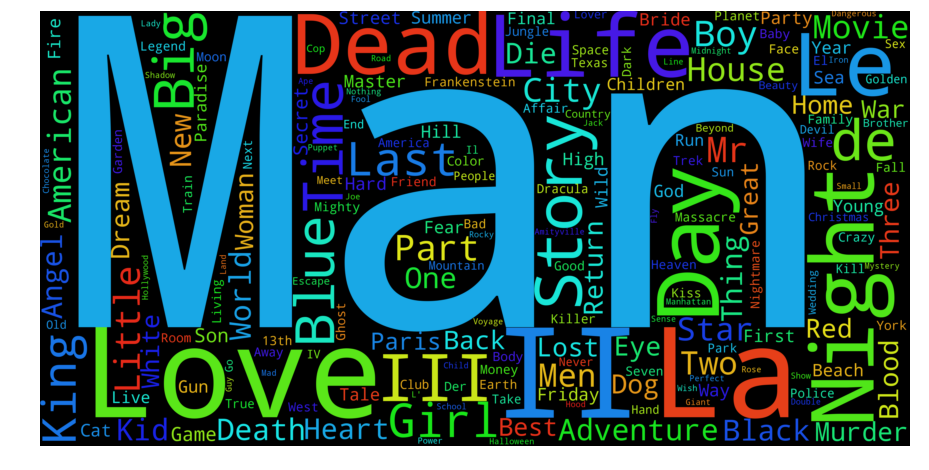

In [90]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud,interpolation='bilinear')
plt.axis('off');


In [55]:
#Overview first 5 rows of ratings dataset
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [72]:
print(ratings.shape)
print(list(ratings.columns))

(1000209, 3)
['user_id', 'movie_id', 'rating']


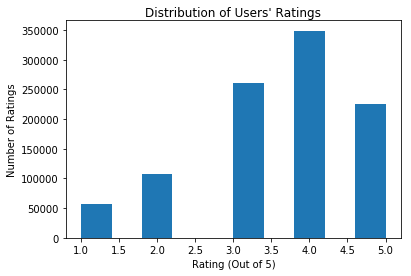

In [92]:
ratings.rating.plot.hist(bins=10)
plt.title("Distribution of Users' Ratings")
plt.ylabel('Number of Ratings')
plt.xlabel('Rating (Out of 5)');

BUILD SVD Recomendation Engine:
reference:https://datascienceplus.com/building-a-book-recommender-system-the-basics-knn-and-matrix-factorization/
          https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html

In [56]:
#Build pivot tables:columns with unique movie_id, rows with unique user_id
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
#Overview the first 5 raws of pivot table
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
print(type(Ratings))
print(Ratings.shape)

<class 'pandas.core.frame.DataFrame'>
(6040, 3706)


In [77]:
#De-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.
R = Ratings.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)
print(type(Ratings_demeaned))

C:\Users\tbao\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


<class 'numpy.ndarray'>


In [79]:
from scipy.sparse.linalg import svds
print(ratings.shape)

(1000209, 3)


In [60]:
sigma = np.diag(sigma)

In [61]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [62]:
#Build prediction matrix for every user
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244


In [78]:
print(preds.shape)

(6040, 3706)


In [80]:
#Write function to predict highest rating movies that the specified user has not rated.
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    user_row_number = userID - 1 
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False)     
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )
    print(userID, user_full.shape[0])
    print(num_recommendations)
    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [82]:
#Top 20 movies that User "275" has not rated 
already_rated, predictions = recommend_movies(preds, 275, movies, ratings, 20)

275 89
20


In [83]:
#Top 20 movies which user 275 will like
already_rated.head(20)

,user_id,movie_id,rating,title,genres
0,275,2987,5,Who Framed Roger Rabbit? (1988),Adventure|Animation|Film-Noir
33,275,3169,5,"Falcon and the Snowman, The (1984)",Drama
37,275,3424,5,Do the Right Thing (1989),Comedy|Drama
39,275,3501,5,Murphy's Romance (1985),Comedy|Romance
43,275,3510,5,Frequency (2000),Drama|Thriller
1,275,648,5,Mission: Impossible (1996),Action|Adventure|Mystery
45,275,3526,5,Parenthood (1989),Comedy|Drama
50,275,2739,5,"Color Purple, The (1985)",Drama
51,275,3480,5,Lucas (1986),Drama
53,275,1956,5,Ordinary People (1980),Drama


EVALUATION OF SVD MODEL
http://surpriselib.com/
Suprise library:
The name SurPRISE (roughly :) ) stands for Simple Python RecommendatIon System Engine.
Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.
Provide tools to evaluate, analyse and compare the algorithms performance. Cross-validation procedures can be run very easily using powerful CV iterators (inspired by scikit-learn excellent tools), as well as exhaustive search over a set of parameters.

In [86]:
from surprise import Reader, Dataset, SVD, evaluate

#Split the dataset for 8 folder cross validation
reader = Reader()
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)
data.split(n_folds=8)

In [87]:
#Get RMSE of the SVD Model
svd = SVD()
evaluate(svd, data, measures=['RMSE'])

Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.8719
------------
Fold 2
RMSE: 0.8678
------------
Fold 3
RMSE: 0.8661
------------
Fold 4
RMSE: 0.8674
------------
Fold 5
RMSE: 0.8673
------------
Fold 6
RMSE: 0.8634
------------
Fold 7
RMSE: 0.8675
------------
Fold 8
RMSE: 0.8677
------------
------------
Mean RMSE: 0.8674
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.8719210110490391,
                             0.8678314660196095,
                             0.8661243781664264,
                             0.8674357693439537,
                             0.8672820697503306,
                             0.8633921620192372,
                             0.8674881302264236,
                             0.8677060437101142]})

CONCLUSION:
In Project 2, user-user and item-item collaborative filtering models have very high RSME valuse (>1000).  
RSME of SVD model with RSME score of 0.8674.
In Project 2, we only used 1% of MovieLens data.  Using more than 4% of data, the computer will be dead.
Using SVD model, we used 100% of MovieLens data.  The time for computation is about 10 minutes which is reasonable.
Therefore, SVD model is a much better model.    